In [38]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import seaborn as sns
import cv2
import os
from torchsampler import ImbalancedDatasetSampler

In [39]:
data = []
labels = []
for filename in os.listdir("resized_data/healthycows/"):
    img = cv2.imread("resized_data/healthycows/" + filename)
    data.append(img)
    labels.append(0)
for filename in os.listdir("resized_data/lumpycows/"):
    img = cv2.imread("resized_data/lumpycows/" + filename)
    data.append(img)
    labels.append(1)

c:\Users\husai\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\husai\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<AxesSubplot: ylabel='Count'>

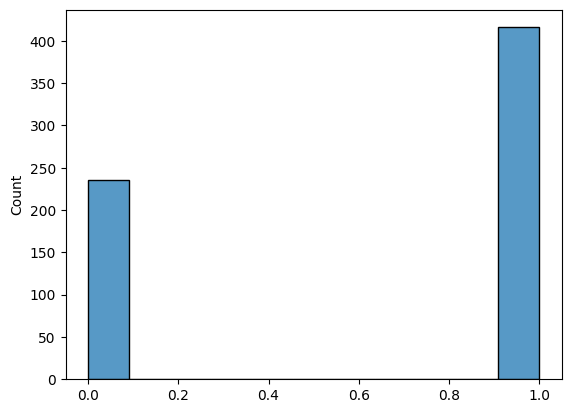

In [40]:
sns.histplot(data=labels)

In [41]:
X_train, X_test_val, y_train, y_test_val = train_test_split(data, labels, test_size=.2, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=.5, shuffle=True)

In [42]:
class LumpyDataset(Dataset):
    def __init__(self, images, labels) -> None:
        self.X = images
        self.y = labels
        # function for images transformations
        # TODO: try AutoAugment(AutoAugmentPolicy.IMAGENET)
        self.random_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(30),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(
                brightness=0.1, contrast=0.1),
            transforms.RandomAffine(
                degrees=(0, 30),
                translate=(0, 0.2),
                scale=(0.9, 1)
            ),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.X)
    
    def get_labels(self):
        return self.y

    def __getitem__(self, index):
        num_augment = 8
        augmented_batch = []
        # creating augmented data
        for i in range(num_augment):
            new_item = self.random_transform(self.X[index])
            augmented_batch.append(new_item)
        # labels with one-hot encoding
        label = torch.Tensor([self.y[index]])

        new_labels = [label, label, label, label, label, label, label, label]

        return torch.stack(augmented_batch), torch.stack(new_labels)

In [43]:
# testing our dataset class
koten_set = LumpyDataset(X_val, y_val)
koten_loader = DataLoader(koten_set, batch_size=16, shuffle=True, drop_last=True)
for X, y in koten_loader:
    print("koten", X.shape, y.shape)
# koten_set[5]

koten torch.Size([16, 8, 3, 225, 225]) torch.Size([16, 8, 1])
koten torch.Size([16, 8, 3, 225, 225]) torch.Size([16, 8, 1])
koten torch.Size([16, 8, 3, 225, 225]) torch.Size([16, 8, 1])
koten torch.Size([16, 8, 3, 225, 225]) torch.Size([16, 8, 1])


In [44]:
# creating datasets from numpy arrays
train_set = LumpyDataset(X_train, y_train)
valid_set = LumpyDataset(X_val, y_val)
test_set = LumpyDataset(X_test, y_test)

In [45]:
# creating data loaders from datasets
train_loader = DataLoader(train_set, batch_size=8,
                          pin_memory=True, drop_last=True,
                          sampler=ImbalancedDatasetSampler(train_set))
valid_loader = DataLoader(valid_set, batch_size=8,
                          pin_memory=True, drop_last=True,
                          sampler=ImbalancedDatasetSampler(valid_set))
test_loader = DataLoader(test_set, batch_size=8,
                         pin_memory=True, drop_last=True,
                         sampler=ImbalancedDatasetSampler(test_set))

In [46]:
# testing data loader
X,y = next(iter(test_loader))
X.shape, y.shape

(torch.Size([8, 8, 3, 225, 225]), torch.Size([8, 8, 1]))

In [47]:
# saving all data loaders
with open("variables/train_loader.pickle", "wb") as f:
    pickle.dump(train_loader, f)
with open("variables/valid_loader.pickle", "wb") as f:
    pickle.dump(valid_loader, f)
with open("variables/test_loader.pickle", "wb") as f:
    pickle.dump(test_loader, f)